# Task 3: Helper notebook for loading the data and saving the predictions

In [5]:
import pickle
import gzip
import numpy as np
import os

### Helper functions

In [6]:
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object

In [7]:
def save_zipped_pickle(obj, filename):
    with gzip.open(filename, 'wb') as f:
        pickle.dump(obj, f, 2)

### Load data, make predictions and save prediction in correct format

In [8]:
# load data
train_data = load_zipped_pickle("train.pkl")
test_data = load_zipped_pickle("test.pkl")
# samples = load_zipped_pickle("sample.pkl")

In [9]:
from tqdm import tqdm
import matplotlib.pyplot as plt

def preprocess_item(item):
    '''
    This function preprocesses an item. It returns the names of the item, the video frames and the mask frames.
    '''
    item_video_frames = []
    item_mask_frames = []
    item_names = []
    video = item['video']
    name = item['name']
    height, width, n_frames = video.shape
    mask = np.zeros((height, width, n_frames), dtype=bool)
    for frame in item['frames']:
        mask[:, :, frame] = item['label'][:, :, frame]
        video_frame = video[:, :, frame]
        mask_frame = mask[:, :, frame]
        video_frame = np.expand_dims(video_frame, axis=2).astype(np.float32)
        mask_frame = np.expand_dims(mask_frame, axis=2).astype(np.int32)
        item_video_frames.append(video_frame)
        item_mask_frames.append(mask_frame)
        item_names.append(name)
    return item_names, item_video_frames, item_mask_frames

def preprocess_train_data(data, select='all'):
    '''
    This function preprocesses the training data. It returns the names of the items, the video frames and the mask frames. 
    The select parameter can be 'all', 'expert' or 'amateur'. 
    '''
    video_frames = []
    mask_frames = []
    names = []
    for item in tqdm(data):
        if select == 'all':
            item_names, item_video_frames, item_mask_frames = preprocess_item(item)
        elif select == 'expert':
            if item['dataset'] == 'expert':
                item_names, item_video_frames, item_mask_frames = preprocess_item(item)
            else: continue
        elif select == 'amateur':
            if item['dataset'] == 'amateur':
                item_names, item_video_frames, item_mask_frames = preprocess_item(item)
            else: continue
        else: raise ValueError('Invalid select')
        video_frames += item_video_frames
        mask_frames += item_mask_frames
        names += item_names

    return names, video_frames, mask_frames

def preprocess_test_data(data):
    video_frames = []
    names = []
    for item in tqdm(data):
        video = item['video']
        video = video.astype(np.float32).transpose((2, 0, 1))
        video = np.expand_dims(video, axis=3)
        video_frames += list(video)
        names += [item['name'] for _ in video]
    return names, video_frames

In [10]:
# Extract the expert and amateur training data separately
train_names_expert, train_videos_expert, train_masks_expert = preprocess_train_data(train_data, select='expert')
train_names_amateur, train_videos_amateur, train_masks_amateur = preprocess_train_data(train_data, select='amateur')
# Extract test data
test_names, test_videos = preprocess_test_data(test_data)

  0%|          | 0/65 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:07<00:00,  2.76it/s]


In [11]:
# check how many frames we have for each dataset
num_expert_videos = len(train_videos_expert)
num_amateur_videos = len(train_videos_amateur)
num_test_videos = len(test_videos)

print(f"Number of expert videos: {num_expert_videos}")
print(f"Number of amateur videos: {num_amateur_videos}")
print(f"Number of test videos: {num_test_videos}")

Number of expert videos: 57
Number of amateur videos: 138
Number of test videos: 1507


So we have 19 expert videos containing 57 labeled frames and 46 amateur videos containing 138 labeled frames.

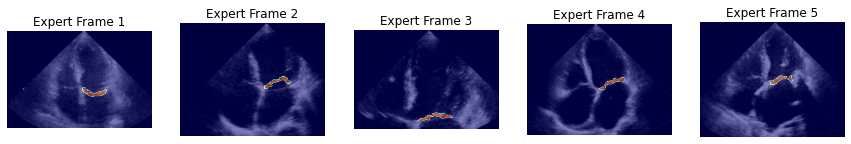

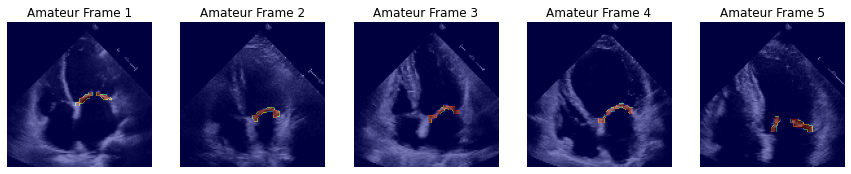

In [9]:
import random

import matplotlib.pyplot as plt

# Function to plot frames with masks
def plot_frames_with_masks(videos, masks, num_frames, title):
    fig, axes = plt.subplots(1, num_frames, figsize=(15, 5))
    selected_indices = random.sample(range(0, len(videos), 3), num_frames)
    for i, idx in enumerate(selected_indices):
        axes[i].imshow(videos[idx][:, :, 0], cmap='gray')
        axes[i].imshow(masks[idx][:, :, 0], cmap='jet', alpha=0.5)
        axes[i].set_title(f'{title} Frame {i+1}')
        axes[i].axis('off')
    plt.show()

# Plot 5 random frames from expert dataset
plot_frames_with_masks(train_videos_expert, train_masks_expert, 5, 'Expert')

# Plot 5 random frames from amateur dataset
plot_frames_with_masks(train_videos_amateur, train_masks_amateur, 5, 'Amateur')

Minimum frame size: 112x112
Maximum frame size: 731x863


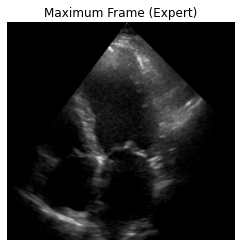

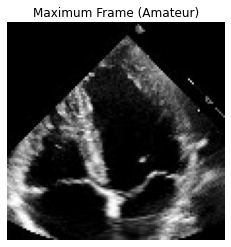

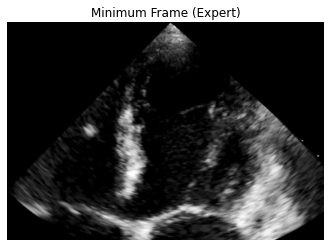

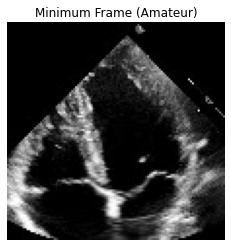

In [14]:
# Check minimum frame size
min_height_expert = min([frame.shape[0] for frame in train_videos_expert])
min_width_expert = min([frame.shape[1] for frame in train_videos_expert])

min_height_amateur = min([frame.shape[0] for frame in train_videos_amateur])
min_width_amateur = min([frame.shape[1] for frame in train_videos_amateur])

min_height = min(min_height_expert, min_height_amateur)
min_width = min(min_width_expert, min_width_amateur)

print(f"Minimum frame size: {min_height}x{min_width}")

# Check maximum frame size
max_height_expert = max([frame.shape[0] for frame in train_videos_expert])
max_width_expert = max([frame.shape[1] for frame in train_videos_expert])

max_height_amateur = max([frame.shape[0] for frame in train_videos_amateur])
max_width_amateur = max([frame.shape[1] for frame in train_videos_amateur])

max_height = max(max_height_expert, max_height_amateur)
max_width = max(max_width_expert, max_width_amateur)

print(f"Maximum frame size: {max_height}x{max_width}")

# Function to plot a frame
def plot_frame(frame, title):
    plt.imshow(frame[:, :, 0], cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Plot the maximum frame
max_frame_expert = train_videos_expert[np.argmax([frame.shape[0] for frame in train_videos_expert])]
max_frame_amateur = train_videos_amateur[np.argmax([frame.shape[0] for frame in train_videos_amateur])]
plot_frame(max_frame_expert, 'Maximum Frame (Expert)')
plot_frame(max_frame_amateur, 'Maximum Frame (Amateur)')

# Plot the minimum frame
min_frame_expert = train_videos_expert[np.argmin([frame.shape[0] for frame in train_videos_expert])]
min_frame_amateur = train_videos_amateur[np.argmin([frame.shape[0] for frame in train_videos_amateur])]
plot_frame(min_frame_expert, 'Minimum Frame (Expert)')
plot_frame(min_frame_amateur, 'Minimum Frame (Amateur)')

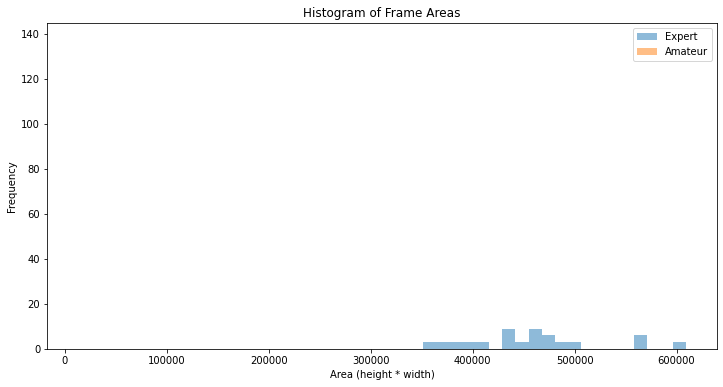

In [15]:
# Calculate the areas of the frames
areas_expert = [frame.shape[0] * frame.shape[1] for frame in train_videos_expert]
areas_amateur = [frame.shape[0] * frame.shape[1] for frame in train_videos_amateur]

# Plot histograms
plt.figure(figsize=(12, 6))

plt.hist(areas_expert, bins=20, alpha=0.5, label='Expert')
plt.hist(areas_amateur, bins=20, alpha=0.5, label='Amateur')

plt.xlabel('Area (height * width)')
plt.ylabel('Frequency')
plt.title('Histogram of Frame Areas')
plt.legend(loc='upper right')

plt.show()

In [23]:
areas_amateur

[12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,
 12544,


### From the flattented array, retrieve indices and length for submission format

In [ ]:
def get_sequences(arr):
    first_indices, last_indices, lengths = [], [], []
    n, i = len(arr), 0
    arr = [0] + list(arr) + [0]
    for index, value in enumerate(arr[:-1]):
        if arr[index+1]-arr[index] == 1:
            first_indices.append(index)
        if arr[index+1]-arr[index] == -1:
            last_indices.append(index)
    lengths = list(np.array(last_indices)-np.array(first_indices))
    return first_indices, lengths

### Create .csv in submission format

In [ ]:
import pandas as pd

df = pd.DataFrame({"id":ids, "value":[list(map(int, minili)) for minili in values]})
df.to_csv(f"mysubmissionfile_{THRESHOLD}.csv", index=False)